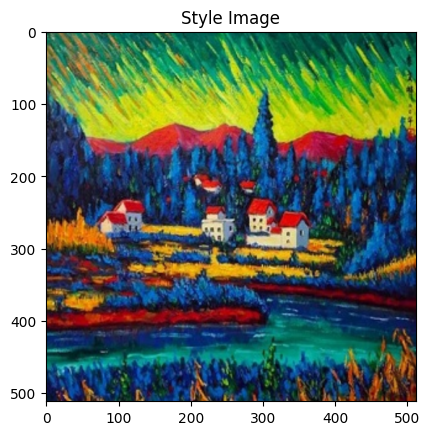

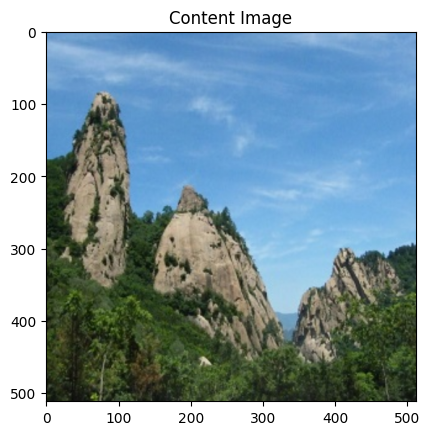

e:\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


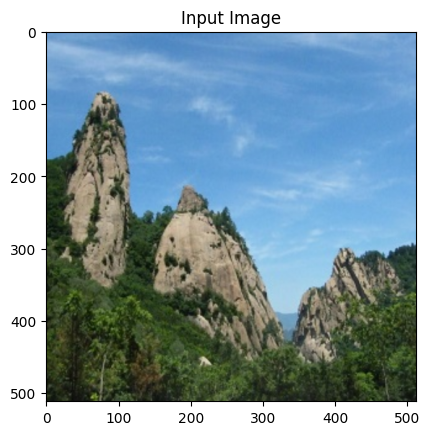

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 385.515167 Content Loss: 24.856949



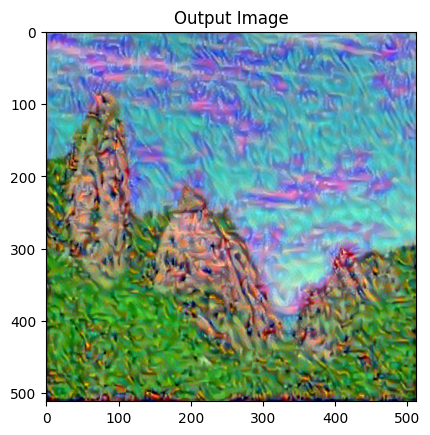

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
from PIL import Image
import matplotlib.pyplot as plt
 
import torchvision.transforms as transforms
import torchvision.models as models
 
import copy
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 来判断是否有可用的GPU
 
                                                                       # 输出图像的所需尺寸
imsize = 512 if torch.cuda.is_available() else 128                     # 如果没有GPU，请使用小尺寸
 
loader = transforms.Compose([
    transforms.Resize(imsize),                                         # 缩放导入的图像
    transforms.ToTensor()])                                            # 将其转换为torch tensor
 
 
def image_loader(image_name):
    image = Image.open(image_name)
 
    image = loader(image).unsqueeze(0)                                 # 需要伪造的批次尺寸以适合网络的输入尺寸
    return image.to(device, torch.float)
style_img = image_loader("../images/5.jpg")
content_img = image_loader("../images/4.jpg")
assert style_img.size() == content_img.size(), \
    "我们需要导入相同大小的样式和内容图像"
unloader = transforms.ToPILImage()                                        # 重新转换为PIL图像
plt.ion()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()                                        # 我们克隆张量不对其进行更改
    image = image.squeeze(0)                                            # 删除假批次尺寸
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)                                                     # 稍停一下，以便更新地块
 
 
plt.figure()
imshow(style_img, title='Style Image')
 
plt.figure()
imshow(content_img, title='Content Image')
 
 
class ContentLoss(nn.Module):
 
    def __init__(self, target, ):
        super(ContentLoss, self).__init__()
 
        # 我们将目标内容与所使用的树“分离”
        # 动态计算梯度：这是一个规定值，
        # 不是变量。 否则，准则的前进方法
        # 将引发错误。
        self.target = target.detach()
 
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
 
 
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=特征图数量
    # (c,d)=dimensions of a f. map (N=c*d)
 
    features = input.view(a * b, c * d)  # 将FXML调整为\ hat FXML
 
    G = torch.matmul(features, features.t())
 
    # 我们将gram矩阵的值“规范化”
    # 除以每个要素图中的元素数量。
    return G.div(a * b * c * d)
 
 
class StyleLoss(nn.Module):
 
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
 
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
 
 
cnn = models.vgg19(pretrained=True).features.to(device).eval()
 
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
 
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
 
 
# 创建一个模块来标准化输入图像，以便我们可以轻松地将其放入
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # 查看均值和标准差以使其为[C x 1 x 1]，以便它们可以
        # 直接使用形状为[B x C x H x W]的图像张量。
        # B是批量大小。 C是通道数。 H是高度，W是宽度。
        # self.mean = torch.tensor(mean).view(-1, 1, 1)
        # self.std = torch.tensor(std).view(-1, 1, 1)
 
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)
 
    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
 
 
# 所需的深度层以计算样式/内容损失：
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
 
 
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
 
    # 标准化模块
    normalization = Normalization(normalization_mean, normalization_std).to(device)
 
    # 只是为了获得对内容/样式的可迭代访问或列表
    # losses
    content_losses = []
    style_losses = []
 
    # 假设cnn是nn.Sequential，那么我们创建一个新的nn.Sequential
    # 放入应该顺序激活的模块
    model = nn.Sequential(normalization)
 
    i = 0  # 每当转换时就增加
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):              #如果对象的类型与参数二的类型（classinfo）相同则返回 True，否则返回 False
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # 旧版本与我们在下面插入的ContentLoss和StyleLoss不能很好地配合使用。
            # 因此，我们在这里替换为不适当的。
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
 
        model.add_module(name, layer)
 
        if name in content_layers:
            # 增加内容损失:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
 
        if name in style_layers:
            # 增加样式损失:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
 
    # 现在我们在最后一次内容和样式丢失后修剪图层
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
 
    model = model[:(i + 1)]
 
    return model, style_losses, content_losses
 
 
input_img = content_img.clone()
# 如果要使用白噪声，请取消注释以下行：
# input_img = torch.randn(content_img.data.size(), device=device)
 
# 将原始输入图像添加到图中：
plt.figure()
imshow(input_img, title='Input Image')
 
 
def get_input_optimizer(input_img):
    # 此行显示输入是需要渐变的参数
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer
 
 
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=50,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                     normalization_mean, normalization_std, style_img,
                                                                     content_img)
    optimizer = get_input_optimizer(input_img)
 
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
 
        def closure():
            # 更正更新后的输入图像的值
            input_img.data.clamp_(0, 1)
 
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
 
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
 
            style_score *= style_weight
            content_score *= content_weight
 
            loss = style_score + content_score
            loss.backward()
 
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
 
            return style_score + content_score
 
        optimizer.step(closure)
 
    # 最后更正...
    input_img.data.clamp_(0, 1)
 
    return input_img
 
 
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()